In [13]:
import numpy as np
from scipy.stats import invwishart, invgamma
from scipy.special import logsumexp
from scipy.special import gamma 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

## Data

In [14]:
np.random.seed(42)
true_cov = np.array([[1,0],[0,2]])

## Helper Functions

In [15]:
def gammafn(x,d):
    """Compute the gamma function for a given x and d."""
    init = np.pi**(d*(d-1)/4)
    for i in range(1,d+1):
        init *= gamma(x + (1-i)/2)
        init = np.clip(init, -1e30, 1e30)
    return init

def objective_function_voptimal(v,n,d):
    """Calculate the objective function for voptimal."""
    v = np.clip(v, 1e-30, 1e30)
    term_1 = v*np.log((v+n)/v)
    term_2 = n*np.log((v+n)/n)
    # print((v+n)/v , "v")
    term_3 = np.log(np.clip(gammafn(v/2,d)/gammafn((v+n)/2,d), 1e-30, 1e30))
    return term_1 + term_2 + term_3

def generate_samples(n):
    """Generate samples from a multivariate normal distribution."""
    # size = nx2
    mean = np.array([0,0])
    cov = np.array([[1,0],[0,2]])

    samples = np.random.multivariate_normal(mean,cov,size=n)
    return samples

def get_error(samples, estimate):
    """Calculate the 2nd norm between the samples and the estimate matrices"""
    return np.linalg.norm(samples - estimate)

def plotError(errors, title):
    """Plot the errors for different sample sizes."""
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    for key in errors.keys():
        plt.plot([10, 100, 1000],errors[key], label=key)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel("Sample Size")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

n10 = generate_samples(10)
n100 = generate_samples(100)
n1000 = generate_samples(1000)
errors = {}

## WorkHorses

In [16]:
def mle_estimate(samples:np.ndarray) -> np.ndarray:
    """Maximum Likelihood Estimate of covariance matrix
    samples: nx2 matrix
    returns: 2x2 covariance matrix
    """
    return samples.T@samples/len(samples)

def bayesian_estimate(samples :np.ndarray, delta0: np.ndarray, v0:int) -> np.ndarray:
    """Bayesian estimate of covariance matrix using Inverse Wishart prior
    samples: nxd matrix
    delta0: dxd matrix
    v0: int
    returns: dxd covariance matrix
    """
    n,d = samples.shape
    dof = n + v0
    scale = delta0 + samples.T@samples
    
    # return analytical mean of posterior
    return scale/(dof-d-1)

def bayesian_estimate_using_MC(samples :np.ndarray, delta0: np.ndarray, v0:int) -> np.ndarray:
    """Bayesian estimate of covariance matrix using Inverse Wishart prior
    samples: nxd matrix
    delta0: dxd matrix
    v0: int
    returns: dxd covariance matrix
    """
    n,d = samples.shape
    cov_matrix = samples.T@samples
    vals = []
    for m in [1e3, 1e4, 1e5]:
        sigmas = []
        log_weights = []
        for _ in range(int(m)):
            sigma_j = invwishart.rvs(v0,delta0)
            det_term = (-n/2)*np.log(np.linalg.det(sigma_j))
            exp_term = -0.5*np.trace(np.linalg.inv(sigma_j)@(samples.T@samples))
            sigmas.append(sigma_j)
            log_weights.append(det_term+exp_term)
        log_denominator = logsumexp(log_weights)
        ans = np.zeros((2,2))
        for w,s in zip(log_weights, sigmas):
            ans += np.exp(w-log_denominator)*s
        vals.append(ans)
    return np.array(vals)

def gibbs_sampler(samples :np.ndarray, sigma: np.ndarray, v0:int) -> np.ndarray:
    """Gibbs sampler for covariance matrix for solving hierarchical bayes model
    samples: nxd matrix
    sigma: dxd matrix as an initial guess
    v0: int
    returns: dxd covariance matrix
    """
    n,d = samples.shape
    iter = 1e3
    A_1 = 0.05
    A_2 = 0.05
    cov_matrix = samples.T@samples
    
    sigmas = []
    for i in range(int(iter)):
        a1 = invgamma.rvs((v0+n)/2,scale=v0*(np.linalg.inv(sigma)[0][0])+1/(A_1**2))
        a2 = invgamma.rvs((v0+n)/2,scale=v0*(np.linalg.inv(sigma)[1][1])+1/(A_2**2))
        sigma = invwishart.rvs(v0+d+n-1, 2*v0*np.array([[1/a1,0],[0,1/a2]])+cov_matrix)
        sigmas.append(sigma)
    
    return np.array(sigmas).mean(axis=0)

def EmpiricalBayes(samples :np.ndarray,v0:int) -> np.ndarray:
    """Empirical Bayes estimate of covariance matrix using Inverse Wishart prior
    samples: nxd matrix
    v0: int
    returns: dxd covariance matrix
    """
    n,d = samples.shape
    v_opt = minimize(lambda x: objective_function_voptimal(x,n,d), v0)
    del_opt = v_opt.x[0]/n * samples.T@samples
    #  InvWishart(νopt + n,∆opt + Σn) Calculate the posterior mean
    posterior_mean = (del_opt + samples.T@samples ) / (v_opt.x[0] + n - d - 1)
    return posterior_mean  
        

## Q1

In [17]:
mle_n10 = mle_estimate(n10)
mle_n100 = mle_estimate(n100)
mle_n1000 = mle_estimate(n1000)

# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {mle_n10[0]} \n \t\t{mle_n10[1]} \t", f"Error : {get_error(true_cov, mle_n10)}" , "\n")
print(f"N100 estimate : {mle_n100[0]} \n \t\t{mle_n100[1]} \t", f"Error : {get_error(true_cov, mle_n100)}", "\n")
print(f"N1000 estimate : {mle_n1000[0]} \n \t\t{mle_n1000[1]} \t", f"Error : {get_error(true_cov, mle_n1000)}" , "\n")  
errors['MLE'] = [get_error(true_cov, mle_n10), get_error(true_cov, mle_n100), get_error(true_cov, mle_n1000)]

N10 estimate : [0.95639504 0.5114831 ] 
 		[0.5114831  1.70687007] 	 Error : 0.78170100869855 

N100 estimate : [1.09090575 0.06765193] 
 		[0.06765193 1.42585811] 	 Error : 0.5891148760120036 

N1000 estimate : [ 1.00312518 -0.00914911] 
 		[-0.00914911  1.92430787] 	 Error : 0.07685361366732414 



## Q2

In [18]:
delta0 = np.array([[4,0],[0,5]])
v0 = 5
bayes_invwis_n10 = bayesian_estimate(n10, delta0, v0)
bayes_invwis_n100 = bayesian_estimate(n100, delta0, v0)
bayes_invwis_n1000 = bayesian_estimate(n1000, delta0, v0)

# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {bayes_invwis_n10[0]} \n \t\t{bayes_invwis_n10[1]} \t", f"Error : {get_error(true_cov, bayes_invwis_n10)}" , "\n")
print(f"N100 estimate : {bayes_invwis_n100[0]} \n \t\t{bayes_invwis_n100[1]} \t", f"Error : {get_error(true_cov, bayes_invwis_n100)}", "\n")
print(f"N1000 estimate : {bayes_invwis_n1000[0]} \n \t\t{bayes_invwis_n1000[1]} \t", f"Error : {get_error(true_cov, bayes_invwis_n1000)}" , "\n")  
errors['Bayes Inv Wishart'] = [get_error(true_cov, bayes_invwis_n10), get_error(true_cov, bayes_invwis_n100), get_error(true_cov, bayes_invwis_n1000)]

N10 estimate : [1.1303292  0.42623591] 
 		[0.42623591 1.83905839] 	 Error : 0.6373711732031411 

N100 estimate : [1.10873113 0.06632542] 
 		[0.06632542 1.44691971] 	 Error : 0.5714178737942226 

N1000 estimate : [ 1.00511495 -0.00913085] 
 		[-0.00913085  1.92545696] 	 Error : 0.07582593953464452 



## Q3

In [19]:
delta0 = np.array([[0,0],[0,0]])
v0 = 1
jeffery_n10 = bayesian_estimate(n10, delta0, v0)
jeffery_n100 = bayesian_estimate(n100, delta0, v0)
jeffery_n1000 = bayesian_estimate(n1000, delta0, v0)

# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {jeffery_n10[0]} \n \t\t{jeffery_n10[1]} \t", f"Error : {get_error(true_cov, jeffery_n10)}" , "\n")
print(f"N100 estimate : {jeffery_n100[0]} \n \t\t{jeffery_n100[1]} \t", f"Error : {get_error(true_cov, jeffery_n100)}", "\n")
print(f"N1000 estimate : {jeffery_n1000[0]} \n \t\t{jeffery_n1000[1]} \t", f"Error : {get_error(true_cov, jeffery_n1000)}" , "\n") 
print("\n")
errors['Bayes Jeffery'] = [get_error(true_cov, jeffery_n10), get_error(true_cov, jeffery_n100), get_error(true_cov, jeffery_n1000)]

v0 = 0
jeffery_ind_n10 = bayesian_estimate(n10, delta0, v0)
jeffery_ind_n100 = bayesian_estimate(n100, delta0, v0)
jeffery_ind_n1000 = bayesian_estimate(n1000, delta0, v0)


# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {jeffery_ind_n10[0]} \n \t\t{jeffery_ind_n10[1]} \t", f"Error : {get_error(true_cov, jeffery_ind_n10)}" , "\n")
print(f"N100 estimate : {jeffery_ind_n100[0]} \n \t\t{jeffery_ind_n100[1]} \t", f"Error : {get_error(true_cov, jeffery_ind_n100)}", "\n")
print(f"N1000 estimate : {jeffery_ind_n1000[0]} \n \t\t{jeffery_ind_n1000[1]} \t", f"Error : {get_error(true_cov, jeffery_ind_n1000)}" , "\n")  
errors['Bayes Jeffery Ind'] = [get_error(true_cov, jeffery_ind_n10), get_error(true_cov, jeffery_ind_n100), get_error(true_cov, jeffery_ind_n1000)]

N10 estimate : [1.1954938  0.63935387] 
 		[0.63935387 2.13358758] 	 Error : 0.9346711809305068 

N100 estimate : [1.11316913 0.06903258] 
 		[0.06903258 1.45495725] 	 Error : 0.5651635564589236 

N1000 estimate : [ 1.00513545 -0.00916745] 
 		[-0.00916745  1.9281642 ] 	 Error : 0.07317676920946582 



N10 estimate : [1.36627863 0.73069014] 
 		[0.73069014 2.43838581] 	 Error : 1.180744813626069 

N100 estimate : [1.1246451  0.06974426] 
 		[0.06974426 1.46995681] 	 Error : 0.5533630885390415 

N1000 estimate : [ 1.00614361 -0.00917664] 
 		[-0.00917664  1.93009816] 	 Error : 0.07136127951600006 



## Q4

In [20]:
delta0 = np.array([[4,0],[0,5]])
v0 = 5
mc_a_n10 = bayesian_estimate_using_MC(n10, delta0, v0)
mc_a_n100 = bayesian_estimate_using_MC(n100, delta0, v0)
mc_a_n1000 = bayesian_estimate_using_MC(n1000, delta0, v0)

# print(f"  Estimate  \t|\t Error \n")

print(f"N10 estimate : {mc_a_n10[0]} \n \t\t{mc_a_n10[1]}\n \t\t{mc_a_n10[2]} \t", f"Error : {[get_error(true_cov, x) for x in mc_a_n10] }" , "\n")
print(f"N100 estimate : {mc_a_n100[0]} \n \t\t{mc_a_n100[1]}\n \t\t{mc_a_n100[2]} \t", f"Error : {[get_error(true_cov, x) for x in mc_a_n100]}", "\n")
print(f"N1000 estimate : {mc_a_n1000[0]} \n \t\t{mc_a_n1000[1]}\n \t\t{mc_a_n1000[2]} \t", f"Error : {[get_error(true_cov, x) for x in mc_a_n1000]}" , "\n") 
print("\n")
errors['MC Bayes with prior 1'] = [get_error(true_cov, mc_a_n10[-1]), get_error(true_cov, mc_a_n100[-1]), get_error(true_cov, mc_a_n1000[-1])]

delta0 = np.array([[2,0],[0,4]])
mc_b_n10 = bayesian_estimate_using_MC(n10, delta0, v0)
mc_b_n100 = bayesian_estimate_using_MC(n100, delta0, v0)
mc_b_n1000 = bayesian_estimate_using_MC(n1000, delta0, v0)
errors['MC Bayes with prior 2'] = [get_error(true_cov, mc_a_n10[-1]), get_error(true_cov, mc_a_n100[-1]), get_error(true_cov, mc_a_n1000[-1])]

# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {mc_b_n10[0]} \n \t\t{mc_b_n10[1]}\n \t\t{mc_b_n10[2]} \t", f"Error : {[get_error(true_cov, x) for x in mc_b_n10]}" , "\n")
print(f"N100 estimate : {mc_b_n100[0]} \n \t\t{mc_b_n100[1]}\n \t\t{mc_b_n100[2]} \t", f"Error : {[get_error(true_cov, x) for x in mc_b_n100]}", "\n")
print(f"N1000 estimate : {mc_b_n1000[0]} \n \t\t{mc_b_n1000[1]}\n \t\t{mc_b_n1000[2]} \t", f"Error : {[get_error(true_cov, x) for x in mc_b_n1000]}" , "\n")  

N10 estimate : [[1.14129646 0.4391255 ]
 [0.4391255  1.8550617 ]] 
 		[[1.12893434 0.42543021]
 [0.42543021 1.85862931]]
 		[[1.13334631 0.42784017]
 [0.42784017 1.84550338]] 	 Error : [0.6531724225815151, 0.6313410096944304, 0.6385490322791338] 

N100 estimate : [[1.0993606  0.02851408]
 [0.02851408 1.45751182]] 
 		[[1.11800412 0.06566948]
 [0.06566948 1.46410161]]
 		[[1.11463093 0.06558901]
 [0.06558901 1.44739235]] 	 Error : [0.5529846831502834, 0.5565402184334348, 0.5719434477090595] 

N1000 estimate : [[ 1.06061303 -0.1206178 ]
 [-0.1206178   1.9168524 ]] 
 		[[ 0.97676615 -0.01620523]
 [-0.01620523  1.91105703]]
 		[[ 1.00340928 -0.01092431]
 [-0.01092431  1.92137923]] 	 Error : [0.1992103655066356, 0.09474113857200032, 0.08019681543101649] 



N10 estimate : [[0.97203399 0.44348641]
 [0.44348641 1.80157382]] 
 		[[0.96247224 0.42504859]
 [0.42504859 1.74646239]]
 		[[0.9650149  0.42792172]
 [0.42792172 1.76114489]] 	 Error : [0.6584188945503935, 0.6534694012063803, 0.651544099

## Q5

In [21]:
sigma0 = np.array([[4,0],[0,5]])
v0 = 5
gibbs_n10 = gibbs_sampler(n10, sigma0, v0)
gibbs_n100 = gibbs_sampler(n100, sigma0, v0)
gibbs_n1000 = gibbs_sampler(n1000, sigma0, v0)
errors['Gibbs'] = [get_error(true_cov, gibbs_n10), get_error(true_cov, gibbs_n100), get_error(true_cov, gibbs_n1000)]
# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {gibbs_n10[0]} \n \t\t{gibbs_n10[1]} \t", f"Error : {get_error(true_cov, gibbs_n10)}" , "\n")
print(f"N100 estimate : {gibbs_n100[0]} \n \t\t{gibbs_n100[1]} \t", f"Error : {get_error(true_cov, gibbs_n100)}", "\n")
print(f"N1000 estimate : {gibbs_n1000[0]} \n \t\t{gibbs_n1000[1]} \t", f"Error : {get_error(true_cov, gibbs_n1000)}" , "\n") 
print("\n")

N10 estimate : [0.76111874 0.39952346] 
 		[0.39952346 1.34553095] 	 Error : 0.8970128115463586 

N100 estimate : [1.07811841 0.07162949] 
 		[0.07162949 1.4067706 ] 	 Error : 0.606865036534499 

N1000 estimate : [ 1.01422769 -0.00790165] 
 		[-0.00790165  1.93181485] 	 Error : 0.07054440778760485 





## Q6

In [22]:
v0 = 5
empirical_bayes_n10 = EmpiricalBayes(n10, v0)
empirical_bayes_n100 = EmpiricalBayes(n100, v0)
empirical_bayes_n1000 = EmpiricalBayes(n1000, v0)
errors['Empirical Bayes'] = [get_error(true_cov, empirical_bayes_n10), get_error(true_cov, empirical_bayes_n100), get_error(true_cov, empirical_bayes_n1000)]
# print(f"  Estimate  \t|\t Error \n")
print(f"N10 estimate : {empirical_bayes_n10[0]} \n \t\t{empirical_bayes_n10[1]} \t", f"Error : {get_error(true_cov, empirical_bayes_n10)}" , "\n")
print(f"N100 estimate : {empirical_bayes_n100[0]} \n \t\t{empirical_bayes_n100[1]} \t", f"Error : {get_error(true_cov, empirical_bayes_n100)}", "\n")
print(f"N1000 estimate : {empirical_bayes_n1000[0]} \n \t\t{empirical_bayes_n1000[1]} \t", f"Error : {get_error(true_cov, empirical_bayes_n1000)}" , "\n")

N10 estimate : [1.04157568 0.55703797] 
 		[0.55703797 1.85889121] 	 Error : 0.8013880606137168 

N100 estimate : [1.1246625  0.06974534] 
 		[0.06974534 1.46997955] 	 Error : 0.5533454958740844 

N1000 estimate : [ 1.00614376 -0.00917664] 
 		[-0.00917664  1.93009845] 	 Error : 0.07136100844284828 



In [23]:
errors

{'MLE': [0.78170100869855, 0.5891148760120036, 0.07685361366732414],
 'Bayes Inv Wishart': [0.6373711732031411,
  0.5714178737942226,
  0.07582593953464452],
 'Bayes Jeffery': [0.9346711809305068,
  0.5651635564589236,
  0.07317676920946582],
 'Bayes Jeffery Ind': [1.180744813626069,
  0.5533630885390415,
  0.07136127951600006],
 'MC Bayes with prior 1': [0.6385490322791338,
  0.5719434477090595,
  0.08019681543101649],
 'MC Bayes with prior 2': [0.6385490322791338,
  0.5719434477090595,
  0.08019681543101649],
 'Gibbs': [0.8970128115463586, 0.606865036534499, 0.07054440778760485],
 'Empirical Bayes': [0.8013880606137168,
  0.5533454958740844,
  0.07136100844284828]}

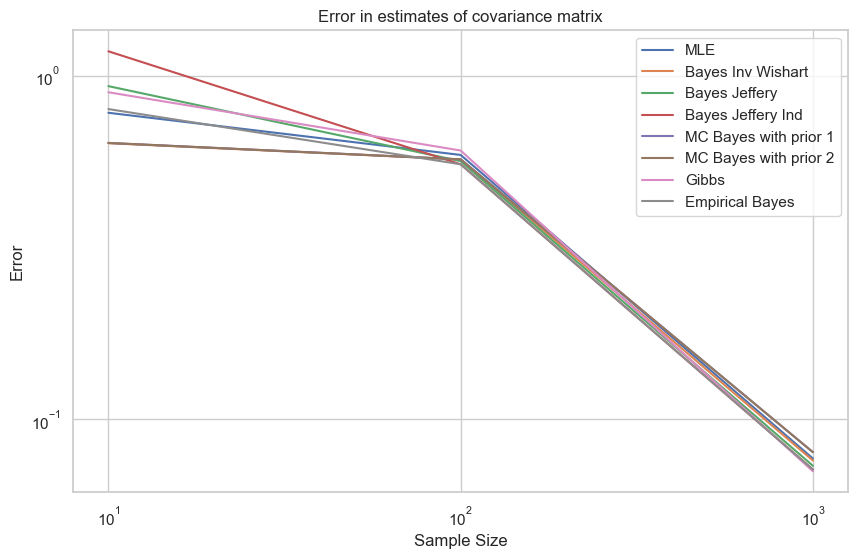

In [24]:
plotError(errors, "Error in estimates of covariance matrix")    